In [1]:
!pip install tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import os
import scipy.io
import h5py
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split


In [2]:

# def _shap_div_no_nan(op, grad):
#     x, y = op.inputs
#     not_zero = tf.greater(tf.abs(y), 1e-12)
#     not_inf = tf.logical_not(tf.logical_or(tf.is_inf(y), tf.is_inf(grad)))
#     valid = tf.logical_and(not_zero, not_inf)
#     return tf.where(valid, grad / y, tf.zeros_like(grad))

# # Register the gradient function with Keras
# K.__dict__["gradients"] = _shap_div_no_nan

**Loading the data and creating pickle file using only one batch**


In [2]:
def load_data(matFilename,pickle_name):
    cycle_scalar_dataset_dict = {}
# 'data/2017-05-12_batchdata_updated_struct_errorcorrect.mat'
    f = h5py.File(matFilename, 'r')
    batch = f['batch']
    #Récupèration de toutes les données dans un dictionnaire général, toutes ne sont pas utiles
    num_cells = batch['summary'].shape[0]
    bat_dict = {}
    for i in range(num_cells):
        cl = f[batch['cycle_life'][i,0]][()] #ici on a remplacé ".value" par "[()]", et dans toutes les lignes suivantes
        policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
        summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
        summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
        summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
        summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
        summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
        summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
        summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
        summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
        summary = ({'IR': summary_IR, #création d'un 1er dict avec les données "résumées", càd 1 donnée par cycle
                   'QC': summary_QC, 
                   'QD': summary_QD, 
                   'Tavg': summary_TA, 
                   'Tmin': summary_TM, 
                   'Tmax': summary_TX, 
                   'chargetime': summary_CT,
                   'cycle': summary_CY}) 
        cycles = f[batch['cycles'][i,0]]
        cycle_dict = {}
        for j in range(cycles['I'].shape[0]):
            I = np.hstack((f[cycles['I'][j,0]][()]))
            Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
            Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
            Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
            T = np.hstack((f[cycles['T'][j,0]][()]))
            Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
            V = np.hstack((f[cycles['V'][j,0]][()]))
            dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
            t = np.hstack((f[cycles['t'][j,0]][()]))
            SOC = np.hstack((f[cycles['Qc'][j,0]][()]-f[cycles['Qd'][j,0]][()])/summary_QC[j])
            cd = ({'I': I,   #création d'un 2è dictionnnaire pour les données temporelles
                   'Qc': Qc, 
                   'Qd': Qd, 
                   'Qdlin': Qdlin, 
                   'T': T, 
                   'Tdlin': Tdlin, 
                   'V':V, 
                   'dQdV': dQdV, 
                   't':t,
                   'SOC' : SOC})
            cycle_dict[str(j)] = cd
            scalar_sample_dict = ({'I': I , 
                                   'T': T , 
                                   'V' : V , 
                                   'SOC':SOC}
                             )
            key = 'b1c' + str(i)+'_cycle_'+str(j)
            bat_dict[key]=   scalar_sample_dict
        
#         cell_dict = ({'cycle_life': cl,  #Compilation des deux dictionnaires dans un seul et même dictionnaire général
#                  'charge_policy':policy, 
#                   'summary': summary, 
#                   'cycles': cycle_dict})
        
#         key = 'b1c' + str(i)
#         bat_dict[key]=   cell_dict
#     with open(pickle_name,'wb') as fp:
#         pickle.dump(bat_dict,fp)

    df =pd.DataFrame(bat_dict)
    return df
  

In [3]:
df1=load_data("C:\\Users\sarbaoui01\\Downloads\\2017-05-12_batchdata_updated_struct_errorcorrect.mat","batch1.pkl")


C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_14272\3769932157.py:40: RuntimeWarning: invalid value encountered in true_divide
  SOC = np.hstack((f[cycles['Qc'][j,0]][()]-f[cycles['Qd'][j,0]][()])/summary_QC[j])


In [4]:
df2=load_data("C:\\Users\\sarbaoui01\\Downloads\\2017-06-30_batchdata_updated_struct_errorcorrect.mat","batch2.pkl")


In [5]:
df3=load_data("C:\\Users\\sarbaoui01\\Downloads\\2018-04-12_batchdata_updated_struct_errorcorrect.mat","batch3.pkl")


In [6]:
df2.append(df1)
df3.append(df2)
# df = pd.concat([df1.T, df2.T, df3.T])

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_14272\3124233174.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2.append(df1)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_14272\3124233174.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3.append(df2)


,b1c0_cycle_0,b1c0_cycle_1,b1c0_cycle_2,b1c0_cycle_3,b1c0_cycle_4,b1c0_cycle_5,b1c0_cycle_6,b1c0_cycle_7,b1c0_cycle_8,b1c0_cycle_9,...,b1c47_cycle_735,b1c47_cycle_736,b1c47_cycle_737,b1c47_cycle_738,b1c47_cycle_739,b1c47_cycle_740,b1c47_cycle_741,b1c47_cycle_742,b1c47_cycle_743,b1c47_cycle_744
I,"[0.5427585909090908, 0.8486348909090908, 1.200...","[0.39175900909090905, 0.7491510545454545, 1.04...","[0.5479257727272726, 0.7937517999999999, 1.098...","[0.39319471818181817, 0.648456918181818, 0.948...","[0.4450329909090909, 0.6991507818181818, 1.101...","[0.5985780181818181, 0.8996131181818181, 1.149...","[0.38626930909090906, 0.6996605636363636, 0.99...","[0.39174513636363634, 0.6990814181818181, 0.99...","[0.3926606636363636, 0.6980618545454544, 0.948...","[0.5982936545454545, 0.8970815454545453, 1.200...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,"[32.08330214381175, 32.08285388769033, 32.0824...","[32.095115420451435, 32.09553350772601, 32.095...","[32.100925, 32.100489412344736, 32.10002811787...","[32.213660487082265, 32.21347621404638, 32.213...","[32.13458411412274, 32.134207367490596, 32.133...","[32.0781864326378, 32.07801845032766, 32.07785...","[32.16671265551257, 32.166497023404254, 32.166...","[32.2562792769949, 32.25600961148094, 32.25579...","[32.22666074610109, 32.22783662607169, 32.2290...","[32.18690692183239, 32.186304016406105, 32.186...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V,"[2.1232638, 2.151546, 2.1923985, 2.2395129, 2....","[2.1120076, 2.1413512, 2.1740165, 2.2118678, 2...","[2.1213861, 2.1444716, 2.1782861, 2.2177253, 2...","[2.1124139, 2.1327176, 2.1629434, 2.1995873, 2...","[2.1151195, 2.1360803, 2.1796918, 2.2119021, 2...","[2.1280026, 2.1573977, 2.1868119, 2.2334542, 2...","[2.1117635, 2.1368032, 2.1684728, 2.2126164, 2...","[2.1137776, 2.1386704, 2.1700406, 2.2142739, 2...","[2.1115088, 2.1361632, 2.1619964, 2.1988816, 2...","[2.1297498, 2.1589379, 2.1943831, 2.2281985, 2...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SOC,"[3.6425423343594824e-06, 3.6425423343594824e-0...","[1.8190609559574564e-06, 1.8190609559574564e-0...","[4.268502521750656e-06, 8.262785835484163e-06,...","[1.2052784522219678e-06, 1.2052784522219678e-0...","[3.5404418809443404e-06, 3.5404418809443404e-0...","[4.339302223894485e-06, 4.339302223894485e-06,...","[-8.179416391580217e-10, -8.179416391580217e-1...","[-1.2263398445432887e-07, -1.2263398445432887e...","[1.5835705166070975e-06, 1.5835705166070975e-0...","[3.6003640957259887e-06, 3.6003640957259887e-0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I,"[0.0, 0.15983060909090907, 0.2496493909090909,...","[0.0, 0.18980286363636362, 0.3098921363636364,...","[0.0, 0.18965460909090906, 0.2997892545454545,...","[0.0, 0.15969536363636364, 0.2898398272727272,...","[0.0, 0.18972483636363635, 0.2797915727272727,...","[0.0, 0.16006036363636364, 0.2796762636363636,...","[0.0, 0.1797554727272727, 0.26958985454545453,...","[0.0, 0.1697705, 0.28992132727272724, 0.389606...","[0.0, 0.17988725454545454, 0.26993664545454543...","[0.0, 0.16986759999999998, 0.26981267272727266...",...,"[0.0, 0.2996583454545454, 0.4787826545454545, ...","[0.0, 0.3628436, 0.5398247454545454, 0.7181549...","[0.0, 0.2951604636363636, 0.47273462727272725,...","[0.3585919454545454, 0.5399981454545455, 0.718...","[0.0, 0.3595421545454545, 0.5395889272727272, ...","[0.0, 0.2995092181818182, 0.4784115909090909, ...","[0.0, 0.2390670818181818, 0.478279809090909, 0...","[0.0, 0.29942946363636364, 0.5394571454545454,...","[0.0, 0.29693949999999997, 0.5387843727272726,...","[0.0, 0.3006675, 0.4756545999999999, 0.6583265..."
T,"[30.076599, 30.076599, 30.076599, 30.076599, 3...","[29.833899, 29.833899, 29.833899, 29.833899, 2...","[28.419994, 28.419994, 28.419994, 28.419994, 2...","[30.129168, 30.129168, 30.129168, 30.129168, 3...","[30.298557, 30.298557, 30.298557, 30.298557, 3...","[28.807995, 28.807995, 28.807995, 28.807995, 2...","[29.946743, 29.946743, 29.946743, 29.946743, 2...","[30.683035, 30.683035, 30.

In [7]:
df=df3.T
df

,I,T,V,SOC
b1c0_cycle_0,"[0.5427585909090908, 0.8486348909090908, 1.200...","[32.08330214381175, 32.08285388769033, 32.0824...","[2.1232638, 2.151546, 2.1923985, 2.2395129, 2....","[3.6425423343594824e-06, 3.6425423343594824e-0..."
b1c0_cycle_1,"[0.39175900909090905, 0.7491510545454545, 1.04...","[32.095115420451435, 32.09553350772601, 32.095...","[2.1120076, 2.1413512, 2.1740165, 2.2118678, 2...","[1.8190609559574564e-06, 1.8190609559574564e-0..."
b1c0_cycle_2,"[0.5479257727272726, 0.7937517999999999, 1.098...","[32.100925, 32.100489412344736, 32.10002811787...","[2.1213861, 2.1444716, 2.1782861, 2.2177253, 2...","[4.268502521750656e-06, 8.262785835484163e-06,..."
b1c0_cycle_3,"[0.39319471818181817, 0.648456918181818, 0.948...","[32.213660487082265, 32.21347621404638, 32.213...","[2.1124139, 2.1327176, 2.1629434, 2.1995873, 2...","[1.2052784522219678e-06, 1.2052784522219678e-0..."
b1c0_cycle_4,"[0.4450329909090909, 0.6991507818181818, 1.101...","[32.13458411412274, 32.134207367490596, 32.133...","[2.1151195, 2.1360803, 2.1796918, 2.2119021, 2...","[3.5404418809443404e-06, 3.5404418809443404e-0..."
...,...,...,...,...
b1c45_cycle_1795,"[0.2578388545454545, 0.4775515454545454, 0.610...","[34.555432606726335, 34.55582969907784, 34.556...","[2.0948563, 2.1100092, 2.1218052, 2.1350965, 2...","[1.7464025659894467e-06, 1.7464025659894467e-0..."
b1c45_cycle_1796,"[0.2599854909090909, 0.478637, 0.6105561727272...","[31.620354294561555, 31.619811574231527, 31.61...","[2.0842285, 2.0998735, 2.1117344, 2.1302576, 2...","[1.5868456535078806e-06, 1.5868456535078806e-0..."
b1c45_cycle_1797,"[0.2594687727272727, 0.47793648181818177, 0.61...","[33.99753668179203, 33.99755672046856, 33.9975...","[2.0886335, 2.1039343, 2.1157856, 2.1292858, 2...","[1.7258779262129827e-06, 1.7258779262129827e-0..."
b1c45_cycle_1798,"[0.2554217272727272, 0.4325623909090909, 0.609...","[32.40957192369549, 32.409422612986646, 32.409...","[2.0888691, 2.1011848, 2.1166267, 2.130477, 2....","[1.408731591259149e-06, 1.408731591259149e-06,..."


In [28]:
# df.to_csv('df1.csv', index=False)

In [29]:
# df1=pd.read_csv("df1.csv")

In [27]:
# df1

In [30]:
# df1['SOC'][1]

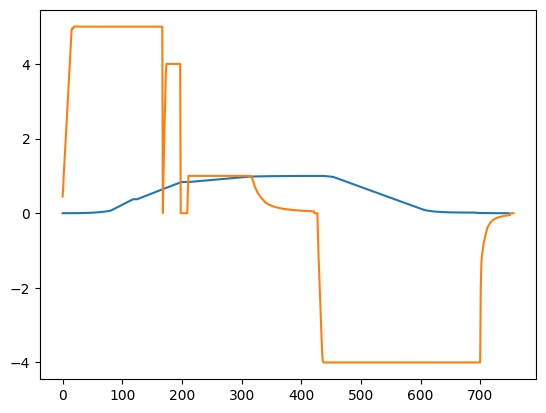

In [8]:
soc=df['SOC']['b1c5_cycle_10']
plt.plot(soc)
I= df['I']['b1c0_cycle_4']
plt.plot(I)

In [189]:
# X_train, X_test, y_train, y_test = train_test_split(
# X, y, test_size=0.2, random_state=0)


In [188]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(3000, activation='relu', input_shape=(3,1000)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(1000, activation='relu')
    
# ])
# model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [33]:
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

In [31]:
# model.predict(X_test[0:1])

In [32]:
# y_test[0]


# SIMPLE MODEL ENDS

In [104]:
df

,I,T,V,SOC
b1c0_cycle_0,"[0.5427585909090908, 0.8486348909090908, 1.200...","[32.08330214381175, 32.08285388769033, 32.0824...","[2.1232638, 2.151546, 2.1923985, 2.2395129, 2....","[3.6425423343594824e-06, 3.6425423343594824e-0..."
b1c0_cycle_1,"[0.39175900909090905, 0.7491510545454545, 1.04...","[32.095115420451435, 32.09553350772601, 32.095...","[2.1120076, 2.1413512, 2.1740165, 2.2118678, 2...","[1.8190609559574564e-06, 1.8190609559574564e-0..."
b1c0_cycle_2,"[0.5479257727272726, 0.7937517999999999, 1.098...","[32.100925, 32.100489412344736, 32.10002811787...","[2.1213861, 2.1444716, 2.1782861, 2.2177253, 2...","[4.268502521750656e-06, 8.262785835484163e-06,..."
b1c0_cycle_3,"[0.39319471818181817, 0.648456918181818, 0.948...","[32.213660487082265, 32.21347621404638, 32.213...","[2.1124139, 2.1327176, 2.1629434, 2.1995873, 2...","[1.2052784522219678e-06, 1.2052784522219678e-0..."
b1c0_cycle_4,"[0.4450329909090909, 0.6991507818181818, 1.101...","[32.13458411412274, 32.134207367490596, 32.133...","[2.1151195, 2.1360803, 2.1796918, 2.2119021, 2...","[3.5404418809443404e-06, 3.5404418809443404e-0..."
...,...,...,...,...
b1c45_cycle_1795,"[0.2578388545454545, 0.4775515454545454, 0.610...","[34.555432606726335, 34.55582969907784, 34.556...","[2.0948563, 2.1100092, 2.1218052, 2.1350965, 2...","[1.7464025659894467e-06, 1.7464025659894467e-0..."
b1c45_cycle_1796,"[0.2599854909090909, 0.478637, 0.6105561727272...","[31.620354294561555, 31.619811574231527, 31.61...","[2.0842285, 2.0998735, 2.1117344, 2.1302576, 2...","[1.5868456535078806e-06, 1.5868456535078806e-0..."
b1c45_cycle_1797,"[0.2594687727272727, 0.47793648181818177, 0.61...","[33.99753668179203, 33.99755672046856, 33.9975...","[2.0886335, 2.1039343, 2.1157856, 2.1292858, 2...","[1.7258779262129827e-06, 1.7258779262129827e-0..."
b1c45_cycle_1798,"[0.2554217272727272, 0.4325623909090909, 0.609...","[32.40957192369549, 32.409422612986646, 32.409...","[2.0888691, 2.1011848, 2.1166267, 2.130477, 2....","[1.408731591259149e-06, 1.408731591259149e-06,..."


In [105]:
# LSTM MODEL STARTS

train_size=int(0.6*len(df))
train_data=df[0:train_size]
test_data=df[train_size:len(df)]

# spliting data for training 0.6 and test 0.4

In [106]:
train_size

30604

In [108]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X=[]
    y=[]
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x.drop(["SOC"],axis=1))
        y.append(seq_y["SOC"])
    return X,y

# preparing data for lstm input 5 output 5

In [109]:
X_train,Y_train = split_sequence(train_data,5,5)
X_test,Y_test = split_sequence(test_data,5,5)
# application


In [110]:
X1=np.array(X_train)
Y1=np.array(Y_train)
X2=np.array(X_test)
Y2=np.array(Y_test)

# from list to array (list cant be indexed with numbers)

In [111]:
def createModel(inputShape,output):
    model = Sequential()
    model.add(LSTM(64,input_shape=inputShape))
    model.add(Dense(output, activation='linear'))
    
    model.compile(loss='mean_squared_error',metrics=['mse'],optimizer="adam")
    return model
# lstm model

In [112]:
time_steps= 5
# lstm model 5
feature_length = 1000
# 3 features
input_shape = (time_steps, feature_length*3)

model= createModel(input_shape, 5000)

In [113]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                784640    
                                                                 
 dense_4 (Dense)             (None, 5000)              325000    
                                                                 
Total params: 1,109,640
Trainable params: 1,109,640
Non-trainable params: 0
_________________________________________________________________


In [114]:
t=np.zeros((len(X1),5,3,1000))
for k in range(len(X1)):
    for i in range(5):
        for x in range(3):
            for j in range(len(X1[k][i][x])):
                if(j>=1000):
                    break
                else:
                    t[k][i][x][j]=X1[k][i][x][j]
# making it with the same length X1                 

In [115]:
X1=t

In [116]:
t=np.zeros((len(X2),5,3,1000))
for k in range(len(X2)):
    for i in range(5):
        for x in range(3):
            for j in range(len(X2[k][i][x])):
                if(j>=1000):
                    break
                else:
                    t[k][i][x][j]=X2[k][i][x][j]
 # making it with the same length      X2                               

In [117]:
X2=t

In [118]:
t=np.zeros((len(Y2),5,1000))
for k in range(len(Y2)):
    for i in range(5):
            for j in range(len(Y2[k][i])):
                if(j>=1000):
                    break
                else:
                    t[k][i][j]=Y2[k][i][j]
                    
                    
# making it with the same length  Y2                                   

In [119]:
Y2=t

In [120]:
t=np.zeros((len(Y1),5,1000))
for k in range(len(Y1)):
    for i in range(5):
            for j in range(len(Y1[k][i])):
                if(j>=1000):
                    break
                else:
                    t[k][i][j]=Y1[k][i][j]
 

 # making it with the same length  Y1               

In [121]:
Y1=t

In [122]:
np.shape(Y2)


(20394, 5, 1000)

In [123]:
X1= np.reshape(X1,(len(X1),5,3000))
X2= np.reshape(X2,(len(X2),5,3000))

# reshaping for the model
#

In [124]:
Y2= np.reshape(Y2,(len(Y2),5000))
Y1= np.reshape(Y1,(len(Y1),5000))
# reshaping fOr the model                

In [125]:
np.shape(Y1)

(30595, 5000)

In [126]:
X1=np.float32(X1)
X2=np.float32(X2)
Y2=np.float32(Y2)

Y1=np.float32(Y1)

# fiting problem solving, cuz the tensor flow couldnt solve it

In [127]:
model.fit(X1,Y1,epochs=10,batch_size=32,validation_data=(X2,Y2))

Epoch 1/10
957/957 [==============================] - 23s 23ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 2/10
957/957 [==============================] - 23s 24ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 3/10
957/957 [==============================] - 23s 24ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 4/10
957/957 [==============================] - 22s 23ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 5/10
957/957 [==============================] - 23s 24ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 6/10
957/957 [==============================] - 23s 24ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 7/10
957/957 [==============================] - 23s 24ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 8/10
957/957 [==============================] - 25s 26ms

In [38]:
model.save("model1.h5")

In [95]:
model1=load_model("model1.h5")

In [96]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                784640    
                                                                 
 dense (Dense)               (None, 5000)              325000    
                                                                 
Total params: 1,109,640
Trainable params: 1,109,640
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 277ms/step


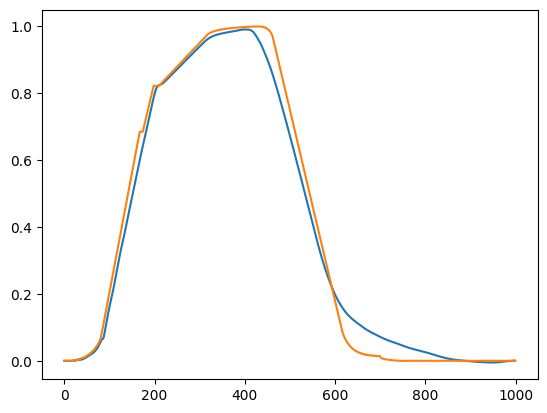

In [128]:
x=model1.predict(X1[1:2])
xx=np.reshape(x,(5,1000))
plt.plot(xx[2])

x=Y1[1:2]
xx=np.reshape(x,(5,1000))
plt.plot(xx[2])


In [8]:
XRF=df.drop(["SOC"],axis=1)
XRF
yRF=df["SOC"]

In [9]:
XRF

,I,T,V
b1c0_cycle_0,"[0.5427585909090908, 0.8486348909090908, 1.200...","[32.08330214381175, 32.08285388769033, 32.0824...","[2.1232638, 2.151546, 2.1923985, 2.2395129, 2...."
b1c0_cycle_1,"[0.39175900909090905, 0.7491510545454545, 1.04...","[32.095115420451435, 32.09553350772601, 32.095...","[2.1120076, 2.1413512, 2.1740165, 2.2118678, 2..."
b1c0_cycle_2,"[0.5479257727272726, 0.7937517999999999, 1.098...","[32.100925, 32.100489412344736, 32.10002811787...","[2.1213861, 2.1444716, 2.1782861, 2.2177253, 2..."
b1c0_cycle_3,"[0.39319471818181817, 0.648456918181818, 0.948...","[32.213660487082265, 32.21347621404638, 32.213...","[2.1124139, 2.1327176, 2.1629434, 2.1995873, 2..."
b1c0_cycle_4,"[0.4450329909090909, 0.6991507818181818, 1.101...","[32.13458411412274, 32.134207367490596, 32.133...","[2.1151195, 2.1360803, 2.1796918, 2.2119021, 2..."
...,...,...,...
b1c45_cycle_1795,"[0.2578388545454545, 0.4775515454545454, 0.610...","[34.555432606726335, 34.55582969907784, 34.556...","[2.0948563, 2.1100092, 2.1218052, 2.1350965, 2..."
b1c45_cycle_1796,"[0.2599854909090909, 0.478637, 0.6105561727272...","[31.620354294561555, 31.619811574231527, 31.61...","[2.0842285, 2.0998735, 2.1117344, 2.1302576, 2..."
b1c45_cycle_1797,"[0.2594687727272727, 0.47793648181818177, 0.61...","[33.99753668179203, 33.99755672046856, 33.9975...","[2.0886335, 2.1039343, 2.1157856, 2.1292858, 2..."
b1c45_cycle_1798,"[0.2554217272727272, 0.4325623909090909, 0.609...","[32.40957192369549, 32.409422612986646, 32.409...","[2.0888691, 2.1011848, 2.1166267, 2.130477, 2...."


In [10]:
# Spliting data trainin, testing

XRF_train, XRF_test, yRF_train, yRF_test = train_test_split(XRF, yRF, test_size = 0.2, shuffle=False)

In [11]:
print(XRF_train.shape, XRF_test.shape, yRF_train.shape, yRF_test.shape)

(40805, 3) (10202, 3) (40805,) (10202,)


In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
modelRF = RandomForestRegressor(n_estimators=100,random_state=42)

In [14]:
XRF1=np.array(XRF_train)
YRF1=np.array(yRF_train)
XRF2=np.array(XRF_test)
YRF2=np.array(yRF_test)


In [15]:
np.shape(YRF1)

(40805,)

In [16]:
t=np.zeros((len(XRF1),3,1000))
for k in range(len(XRF1)):
        for x in range(3):
            for j in range(len(XRF1[k][x])):
                if(j>=1000):
                    break
                else:
                    t[k][x][j]=XRF1[k][x][j]

In [17]:
XRF1=t

In [18]:
t=np.zeros((len(XRF2),3,1000))
for k in range(len(XRF2)):
        for x in range(3):
            for j in range(len(XRF2[k][x])):
                if(j>=1000):
                    break
                else:
                    t[k][x][j]=XRF2[k][x][j]

In [19]:
XRF2=t

In [20]:
t=np.zeros((len(YRF1),1000))
for k in range(len(YRF1)):
            for j in range(len(YRF1[k])):
                if(j>=1000):
                    break
                else:
                    t[k][j]=YRF1[k][j]

In [21]:
YRF1=t

In [22]:
t=np.zeros((len(YRF2),1000))
for k in range(len(YRF2)):
            for j in range(len(YRF2[k])):
                if(j>=1000):
                    break
                else:
                    t[k][j]=YRF2[k][j]

In [23]:
YRF2 = t

In [24]:
np.shape(XRF2)

(10202, 3, 1000)

In [25]:
XRF1= np.reshape(XRF1,(len(XRF1),3*1000))
XRF2= np.reshape(XRF2,(len(XRF2),3*1000))

In [26]:
YRF2= np.reshape(YRF2,(len(YRF2),1000))
YRF1= np.reshape(YRF1,(len(YRF1),1000))

In [27]:
np.shape(YRF1)

(40805, 1000)

In [28]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (3000,)
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
code_size = 32

input_layer = Input(shape=(input_shape))
hidden_layer_1 = Dense(hidden_size1, activation='relu')(input_layer)
hidden_layer_2 = Dense(hidden_size2, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(hidden_size3, activation='relu')(hidden_layer_2)
bottleneck_layer = Dense(code_size, activation='linear')(hidden_layer_3)

# Define the decoder network
hidden_layer_5 = Dense(hidden_size3, activation='relu')(bottleneck_layer)
hidden_layer_6 = Dense(hidden_size2, activation='relu')(hidden_layer_5)
hidden_layer_7 = Dense(hidden_size1, activation='relu')(hidden_layer_6)
output_layer = Dense(3000, activation='linear')(hidden_layer_7) #relu

autoencoder = Model(input_layer, output_layer)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer="adam", loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')



autoencoder.fit(XRF1, XRF1, epochs=20,batch_size=32,
                validation_data=(XRF2, XRF2),
                callbacks=[early_stopping]
              )

Epoch 1/20
1276/1276 [==============================] - 13s 10ms/step - loss: 38.6468 - val_loss: 22.2899
Epoch 2/20
1276/1276 [==============================] - 13s 10ms/step - loss: 22.1756 - val_loss: 18.9601
Epoch 3/20
1276/1276 [==============================] - 12s 9ms/step - loss: 19.5397 - val_loss: 17.5072
Epoch 4/20
1276/1276 [==============================] - 12s 10ms/step - loss: 18.0598 - val_loss: 16.2194
Epoch 5/20
1276/1276 [==============================] - 12s 10ms/step - loss: 16.5450 - val_loss: 14.6098
Epoch 6/20
1276/1276 [==============================] - 13s 10ms/step - loss: 15.4654 - val_loss: 14.2520
Epoch 7/20
1276/1276 [==============================] - 13s 10ms/step - loss: 14.9528 - val_loss: 13.4767
Epoch 8/20
1276/1276 [==============================] - 12s 10ms/step - loss: 14.0454 - val_loss: 12.5400
Epoch 9/20
1276/1276 [==============================] - 13s 10ms/step - loss: 13.2277 - val_loss: 11.7271
Epoch 10/20
1276/1276 [========================

In [29]:
encoderx = Model(input_layer, bottleneck_layer)
encoderx.compile(optimizer='adam', loss='mse')

In [30]:
X11=encoderx.predict(XRF1)
X22=encoderx.predict(XRF2)

319/319 [==============================] - 0s 1ms/step


In [31]:
print(X11.shape,X22.shape)

(40805, 32) (10202, 32)


In [33]:
input_shape = (1000,)
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
code_size = 32

input_layer1 = Input(shape=(input_shape))
hidden_layer_11 = Dense(hidden_size1, activation='relu')(input_layer1)
hidden_layer_22 = Dense(hidden_size2, activation='relu')(hidden_layer_11)
hidden_layer_33 = Dense(hidden_size3, activation='relu')(hidden_layer_22)
bottleneck_layer1 = Dense(code_size, activation='linear')(hidden_layer_33)

# Define the decoder network
hidden_layer_55 = Dense(hidden_size3, activation='relu')(bottleneck_layer1)
hidden_layer_66 = Dense(hidden_size2, activation='relu')(hidden_layer_55)
hidden_layer_77 = Dense(hidden_size1, activation='relu')(hidden_layer_66)
output_layer1 = Dense(1000, activation='relu')(hidden_layer_77)

autoencoder = Model(input_layer1, output_layer1)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer="adam", loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')



autoencoder.fit(YRF1, YRF1, epochs=20,batch_size=32,
                validation_data=(YRF2, YRF2),
                callbacks=[early_stopping]
              )

Epoch 1/20
1276/1276 [==============================] - 5s 4ms/step - loss: 0.0568 - val_loss: 0.0461
Epoch 2/20
1276/1276 [==============================] - 5s 4ms/step - loss: 0.0430 - val_loss: 0.0332
Epoch 3/20
1276/1276 [==============================] - 5s 4ms/step - loss: 0.0289 - val_loss: 0.0251
Epoch 4/20
1276/1276 [==============================] - 5s 4ms/step - loss: 0.0243 - val_loss: 0.0188
Epoch 5/20
1276/1276 [==============================] - 4s 3ms/step - loss: 0.0124 - val_loss: 0.0082
Epoch 6/20
1276/1276 [==============================] - 4s 3ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 7/20
1276/1276 [==============================] - 5s 4ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 8/20
1276/1276 [==============================] - 5s 4ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 9/20
1276/1276 [==============================] - 5s 4ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 10/20
1276/1276 [==============================] - 4s 3ms/step - loss: 0.003

In [41]:
encodery = Model(input_layer1, bottleneck_layer1)
encodery.compile(optimizer='adam', loss='mse')
decoderY=Model(bottleneck_layer1,output_layer1)
decoderY.compile(optimizer='adam', loss='mse')
Y11=encodery.predict(YRF1)
Y22=encodery.predict(YRF2)

319/319 [==============================] - 0s 878us/step


In [36]:
modelRF.fit(X11,Y11)

RandomForestRegressor(random_state=42)

In [38]:
from sklearn.metrics import r2_score
ypred=modelRF.predict(X22)
mse=r2_score(Y22,ypred)
mse

0.7896609699536525

In [43]:
y=decoderY.predict(ypred)

319/319 [==============================] - 0s 931us/step


In [44]:
y.shape

(10202, 1000)

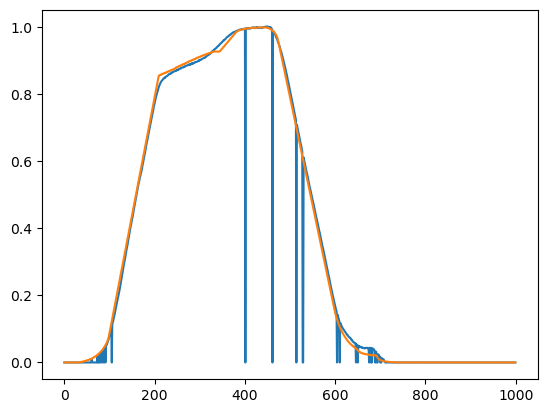

In [46]:
plt.plot(y[0])
plt.plot(YRF2[0])